In [47]:
import sys
import dotenv
import os
dotenv.load_dotenv()
sys.path.append(os.getenv('MAINDIR'))
from main import MoviesDatabase, KeyWords, db
import pandas as pd
import numpy as np

title = [movie.title for movie in MoviesDatabase.query.all()]
id = [movie.id for movie in MoviesDatabase.query.all()]
synopsis = [movie.description for movie in MoviesDatabase.query.all()]
collection = [movie.collection for movie in MoviesDatabase.query.all()]
genre = [movie.genre for movie in MoviesDatabase.query.all()]

In [2]:
from keybert import KeyBERT

kw_model = KeyBERT()
keywords = kw_model.extract_keywords(synopsis, keyphrase_ngram_range=(1, 1), top_n=10)

/home/ksaff/miniconda3/envs/movie_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ksaff/miniconda3/envs/movie_env/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
keywords_words = []
keywords_values = []

for word_list in keywords:
    keywords_words.append([word[0] for word in word_list])
    keywords_values.append([word[1] for word in word_list])

In [19]:
df = pd.DataFrame({'movie_id': id, 'title': title, 'synopsis': synopsis, 'collection': collection, 'genre': genre, 'keywords': keywords_words, 'keyvalues': keywords_values})

In [48]:
all_keyword_ids = []
i = 0
for word_list in keywords_words:
    print(i)
    i += 1
    one_movie_keywords_ids = []
    for word in word_list:
        keyword = KeyWords.query.filter_by(word=word).first()
        if keyword:
            one_movie_keywords_ids.append(keyword.id)
    all_keyword_ids.append(one_movie_keywords_ids)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [77]:
from main import movie_keywords


for keywords_list, movie_id in zip(all_keyword_ids, id):
    for keyword in keywords_list:
        # Create a new record with values for keyword_id and movie_id
        values = {'keyword_id': keyword, 'movie_id': movie_id}
        
        # Use SQLAlchemy's insert method to insert the record
        insert_stmt = movie_keywords.insert().values(**values)
        
        # Execute the insert statement within a session context

        db.session.execute(insert_stmt)

# Commit the changes to the database
db.session.commit()

# Close the session when done
db.session.close()

In [5]:
def get_namelist():
    baby_df = pd.read_csv('babynames.csv')
    namelist = set(baby_df['Name'])
    return namelist

def remove_names(keyword_list, namelist):
    return [word for word in keyword_list if word.capitalize() not in namelist]

namelist = get_namelist()
df['keywords'] = df['keywords'].apply(remove_names, args=(namelist,))

In [6]:
from nltk.stem import WordNetLemmatizer
import nltk

def lemmatize_keywords(keyword_list, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in keyword_list]

lemmatizer = WordNetLemmatizer()

df['keywords'] = df['keywords'].apply(lemmatize_keywords, args=(lemmatizer,))

In [7]:
import gensim.downloader

def delete_unrecognized_keywords(keyword_list, word2vec):
    new_keyword_list = []
    for word in keyword_list:
        try:
           word2vec[word]
           new_keyword_list.append(word)
        except KeyError:
            pass
    return new_keyword_list

wv = gensim.downloader.load('glove-wiki-gigaword-300')
df['keywords'] = df['keywords'].apply(delete_unrecognized_keywords, args=(wv,))

In [8]:
separated_keywords = df.keywords.values
all_keywords = np.array([word for sublist in separated_keywords for word in sublist])

In [9]:
keyword_set = set(all_keywords)

In [15]:
parent_words = []
child_words = []
connection_value = []

i = 0
for word_1 in keyword_set:
    i += 1
    print(i)
    for word_2 in keyword_set:
        similarity = wv.similarity(word_1, word_2)
        if similarity > 0.5:
            parent_words.append(word_1)
            child_words.append(word_2)
            connection_value.append(similarity)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [ ]:
# w2v_df = pd.DataFrame({'parent': parent_words, 'child': child_words, 'value': connection_value})
# w2v_df = w2v_df[w2v_df.groupby('parent')['parent'].transform('count') == 3]

# parent_words = w2v_df['parent'].values
# child_words = w2v_df['child'].values

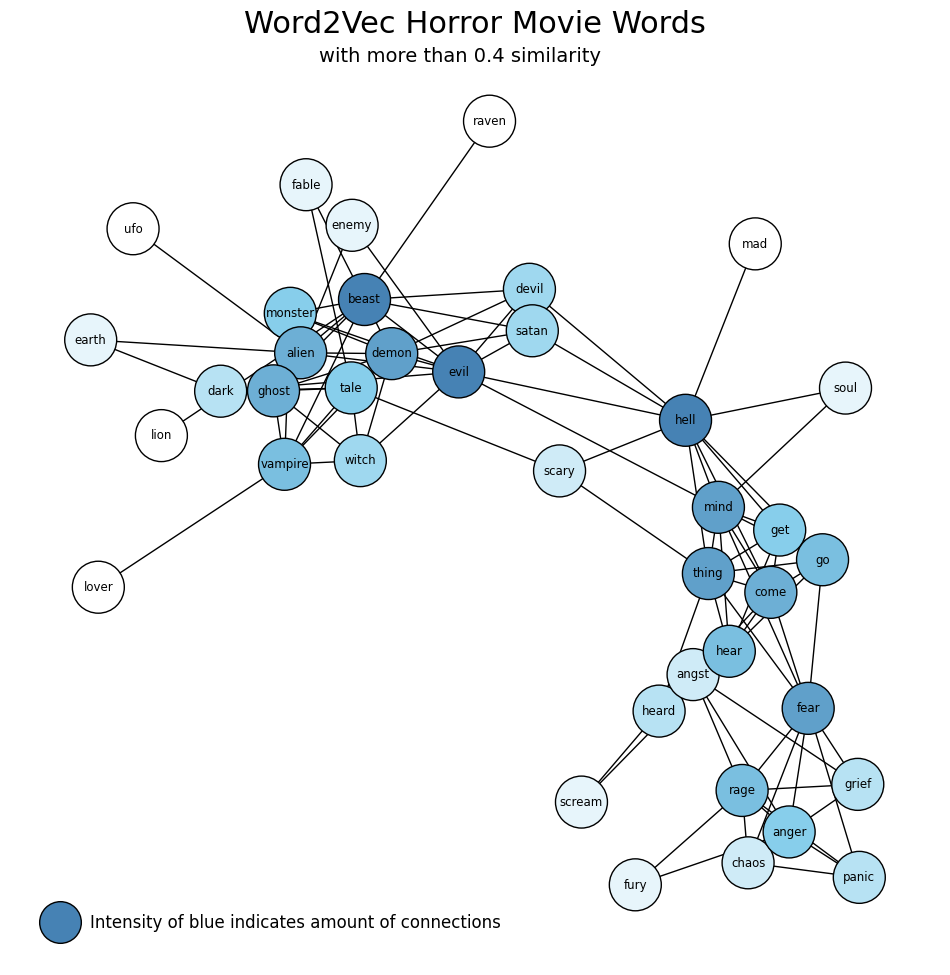

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

custom_colormap = mcolors.LinearSegmentedColormap.from_list(
    'custom_blue', [(0, 'white'), (0.5, 'skyblue'), (1, 'steelblue')]
)

G = nx.Graph()
fig, ax = plt.subplots(figsize=(12, 12))

for word in parent_words:
    G.add_node(word)

edge_labels = {}
for i in range(len(parent_words)):
    parent = parent_words[i]
    child = child_words[i]
    G.add_edge(parent, child)
    edge_labels[(parent, child)] = ""

node_degrees = dict(G.degree)

degrees = [node_degrees[node] for node in G.nodes()]

min_degree = min(degrees) - 100
max_degree = max(degrees)
normalized_degrees = [(degree - min_degree) / (max_degree - min_degree) for degree in degrees]

colormap = custom_colormap

pos = nx.spring_layout(G, k=0.5, seed=12)

nx.draw(G, pos, with_labels=True, node_size=1400, node_color=normalized_degrees, cmap=colormap, font_size=8.5, edgecolors='black', edge_color='black')

plt.title('Word2Vec Horror Movie Words', fontsize=22)
plt.suptitle('with more than 0.4 similarity', fontsize=14, y=0.875)

legend_colors = ['steelblue']
legend_labels = ['Intensity of blue indicates amount of connections']
legend_elements = [Line2D([0], [0], marker='o', linestyle='', color=color, markeredgecolor='black', label=label, markersize=30)
                   for color, label in zip(legend_colors, legend_labels)]
ax.legend(handles=legend_elements, loc='lower left', frameon=False, fontsize=12, bbox_to_anchor=(0.02, 0.02))

plt.show()
